We will be using YOLO v8 for car object detection. This code was ran in a Kaggle environment with GPU P100. 

Importing needed packages.

In [1]:
# Importing needed libraries.
! pip install ultralytics
! pip install pycocotools
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.0/722.0 kB 17.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 10.7 MB/s eta 0:00:0000:01


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Next, I want to create directories. This keeps the data well organized when we need to load it.

In [2]:
!mkdir '/kaggle/working/data'
!mkdir '/kaggle/working/data/train_data'
!mkdir '/kaggle/working/data/train_data/images'
!mkdir '/kaggle/working/data/train_data/labels'
!mkdir '/kaggle/working/data/val_data'
!mkdir '/kaggle/working/data/val_data/images'
!mkdir '/kaggle/working/data/val_data/labels'

Let's load the data now.

In [3]:
# Loading the data.
df = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')

# Check to make sure the data was loaded correctly.
df.head(2)

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180


Everything looks good, so let's head into some data pre-processing!

In [4]:
# Setting the directory where training images are located.
str_dir='/kaggle/input/car-object-detection/data/training_images/'

# Next, we define the width and height of each image.
width=676
height=380

# Here, we assign a default class value of 0.
df["class"]=0

# Rename the column "image" to "img_name".
df.rename(columns={'image':'img_name'}, inplace=True)

# Here, we calculate the center coordinates of the bounding boxes.
df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2

# Calculating height and width of bounding boxes.
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

# Normalizing the bounding box coordinates so they are in the range [0,1].
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

# Creating a new dataframe df_yolo with selected columns.
df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]

# Creating a new column "path" in df with the full path to the images.
df_yolo['path']=str_dir+df_yolo.img_name

# Displaying the first few rows of the df to ensure everything looks correct.
df_yolo.head()

/tmp/ipykernel_32/948586579.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yolo['path']=str_dir+df_yolo.img_name


,img_name,class,x_centre,y_centre,width,height,path
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238,/kaggle/input/car-object-detection/data/traini...
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987,/kaggle/input/car-object-detection/data/traini...
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014,/kaggle/input/car-object-detection/data/traini...
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727,/kaggle/input/car-object-detection/data/traini...
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422,/kaggle/input/car-object-detection/data/traini...


Now, we split the images into training and validation.

In [5]:
train_data, val_data= train_test_split(df_yolo, test_size=0.3, random_state=42) # Saving a test size of 0.3

train_img = '/kaggle/working/data/train_data/images'  # Use "working" as the destination directory.
file_list = train_data.path.values # Path of the file to add
for file_path in file_list:
    dest_path = os.path.join(train_img, os.path.basename(file_path))
    shutil.copy(file_path, dest_path)  

val_img = '/kaggle/working/data/val_data/images'  # Destination directory for validation.
file_list = val_data.path.values # Path of the file to add
for file_path in file_list:
    dest_path = os.path.join(val_img, os.path.basename(file_path))
    shutil.copy(file_path, dest_path)      

We are now creating txt files for validation and testing. We convert into txt because bounding box annotations need to be stored in a format that is able to be easily read and processed during model training. 

In [6]:
# Creating txt file for validation.
val_img = '/kaggle/working/data/val_data/images'
label_dir = '/kaggle/working/data/val_data/labels'
image_file_names = os.listdir(val_img)
for img_name in image_file_names:
    if np.isin(img_name, val_data["img_name"].values):
        columns = ["class", "x_centre", "y_centre", "width", "height"]
        img_bbox = val_data[val_data["img_name"] == img_name][columns].values
        label_file_path = os.path.join(label_dir, img_name[:-4] + ".txt")
        if not os.path.exists(label_file_path):
            with open(label_file_path, "w+") as f:
                for row in img_bbox:
                    text = " ".join(row.astype(str))
                    f.write(text)
                    f.write("\n")
        dest_path = os.path.join(label_dir, os.path.basename(label_file_path))
        if label_file_path != dest_path:
            shutil.copy(label_file_path, dest_path)

In [7]:
# Creating txt file for testing.
train_img = '/kaggle/working/data/train_data/images'
label_dir = '/kaggle/working/data/train_data/labels'
image_file_names = os.listdir(train_img)
for img_name in image_file_names:
    if np.isin(img_name, train_data["img_name"].values):
        columns = ["class", "x_centre", "y_centre", "width", "height"]
        img_bbox = train_data[train_data["img_name"] == img_name][columns].values
        label_file_path = os.path.join(label_dir, img_name[:-4] + ".txt")
        if not os.path.exists(label_file_path):
            with open(label_file_path, "w+") as f:
                for row in img_bbox:
                    text = " ".join(row.astype(str))
                    f.write(text)
                    f.write("\n")
        dest_path = os.path.join(label_dir, os.path.basename(label_file_path))
        if label_file_path != dest_path:
            shutil.copy(label_file_path, dest_path)

Next, we have to create a YAML configuration file that specifies the directory structure and class information required for training a YOLO model.

In [8]:
yolo_format=dict(path="/kaggle/working/data",
                 train="/kaggle/working/data/train_data",
                 val="/kaggle/working/data/val_data",
                 nc=1,
                 names={0:"car"})
             
with open('/kaggle/working/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

Next, we are using the Weights & Biases (wandb) API. This allows for a convenient way for experiment tracking, visualization, and hyperparameter optimization.

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("wandb_api") 
wandb.login(key=my_secret)

# You have to create your own account and API key for this.

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Now, we're ready to train the model!

In [11]:
model=YOLO('yolov8m.pt')
model.train(data="/kaggle/working/yolo.yaml",epochs=20,patience=5,batch=8,lr0=0.0005,imgsz=640)

100%|██████████| 49.7M/49.7M [00:00<00:00, 291MB/s]


Ultralytics YOLOv8.1.30 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolo.yaml, epochs=20, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████| 755k/755k [00:00<00:00, 21.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Currently logged in as: alicia-k-tang (aliciatang). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 120MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/train_data/labels... 277 images, 0 backgrounds, 0 corrupt: 100%|██████████| 277/277 [00:00<00:00, 1054.13it/s]

train: New cache created: /kaggle/working/data/train_data/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/data/val_data/labels... 142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<00:00, 962.16it/s]

val: New cache created: /kaggle/working/data/val_data/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.67G      1.538      1.919      1.278         10        640: 100%|██████████| 35/35 [00:13<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        142        168     0.0753      0.429     0.0647     0.0357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.83G       1.41      1.336       1.28         11        640: 100%|██████████| 35/35 [00:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]

                   all        142        168     0.0043      0.446    0.00324    0.00148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.85G      1.393      1.236      1.398         18        640: 100%|██████████| 35/35 [00:11<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]

                   all        142        168     0.0109      0.643    0.00863    0.00492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.99G      1.401      1.085      1.427         17        640: 100%|██████████| 35/35 [00:11<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]

                   all        142        168      0.459      0.649      0.407      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       4.8G      1.449     0.9613      1.355         11        640: 100%|██████████| 35/35 [00:11<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.62it/s]

                   all        142        168       0.54      0.839      0.647      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.99G      1.376     0.9121      1.348          7        640: 100%|██████████| 35/35 [00:11<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.75it/s]

                   all        142        168      0.572      0.887      0.641      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.97G      1.266     0.8376       1.27         22        640: 100%|██████████| 35/35 [00:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.93it/s]

                   all        142        168      0.524      0.485      0.401      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.89G      1.353     0.9038       1.35         10        640: 100%|██████████| 35/35 [00:11<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.84it/s]

                   all        142        168      0.591      0.929      0.635       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.81G      1.302     0.8472      1.248         12        640: 100%|██████████| 35/35 [00:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.79it/s]

                   all        142        168      0.594      0.857      0.642      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.89G      1.324     0.8491      1.308         14        640: 100%|██████████| 35/35 [00:11<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]

                   all        142        168      0.593      0.869       0.68      0.424


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.81G      1.274     0.8788      1.303          5        640: 100%|██████████| 35/35 [00:11<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.84it/s]

                   all        142        168      0.578       0.97      0.663      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.82G      1.243     0.7862      1.296          6        640: 100%|██████████| 35/35 [00:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]

                   all        142        168      0.574      0.923      0.647      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.84G      1.266     0.8162      1.329          6        640: 100%|██████████| 35/35 [00:11<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.80it/s]

                   all        142        168      0.581      0.964      0.661      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.91G       1.23     0.7665      1.299         15        640: 100%|██████████| 35/35 [00:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]

                   all        142        168      0.583      0.935      0.651      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       4.9G      1.229     0.7531      1.277          8        640: 100%|██████████| 35/35 [00:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.85it/s]

                   all        142        168      0.568      0.916      0.653      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.82G      1.217     0.7402      1.251         12        640: 100%|██████████| 35/35 [00:11<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.89it/s]

                   all        142        168       0.57      0.958      0.644       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.84G      1.202      0.714      1.266          8        640: 100%|██████████| 35/35 [00:11<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.80it/s]

                   all        142        168      0.564      0.963       0.62      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.81G       1.14     0.7161      1.243          7        640: 100%|██████████| 35/35 [00:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]

                   all        142        168      0.571      0.976      0.613      0.401
Stopping training early as no improvement observed in last 5 epochs. Best results observed at epoch 13, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



18 epochs completed in 0.078 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.30 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


                   all        142        168      0.581      0.964      0.658      0.427
Speed: 0.3ms preprocess, 6.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂▅███▇▇▆▆▅▅▄▄▃▃▂▂▁
lr/pg1,▂▅███▇▇▆▆▅▅▄▄▃▃▂▂▁
lr/pg2,▂▅███▇▇▆▆▅▅▄▄▃▃▂▂▁
metrics/mAP50(B),▂▁▁▅██▅█████████▇█
metrics/mAP50-95(B),▂▁▁▄▇▇▅▇██████████
metrics/precision(B),▂▁▁▆▇█▇███████████
metrics/recall(B),▁▁▄▄▆▇▂▇▇▇█▇██▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▆▆▅▃▅▄▄▃▃▃▃▃▂▂▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bc4c7ac1d80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Now, we select the best trained model for our predictions!

In [ ]:
path_best_weights="/kaggle/working/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights) 

We're ready to create our predictions now.

In [14]:
results = model.predict(source='/kaggle/input/car-object-detection/data/testing_images', save=True)


image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 1 car, 89.4ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 12.1ms
image 3/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 12.0ms
image 4/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 12.0ms
image 5/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 12.0ms
image 6/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 12.0ms
image 7/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 12.0ms
image 8/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 12.0ms
image 9/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25260.jp

Time to plot the images and check how well the YOLO models performed.

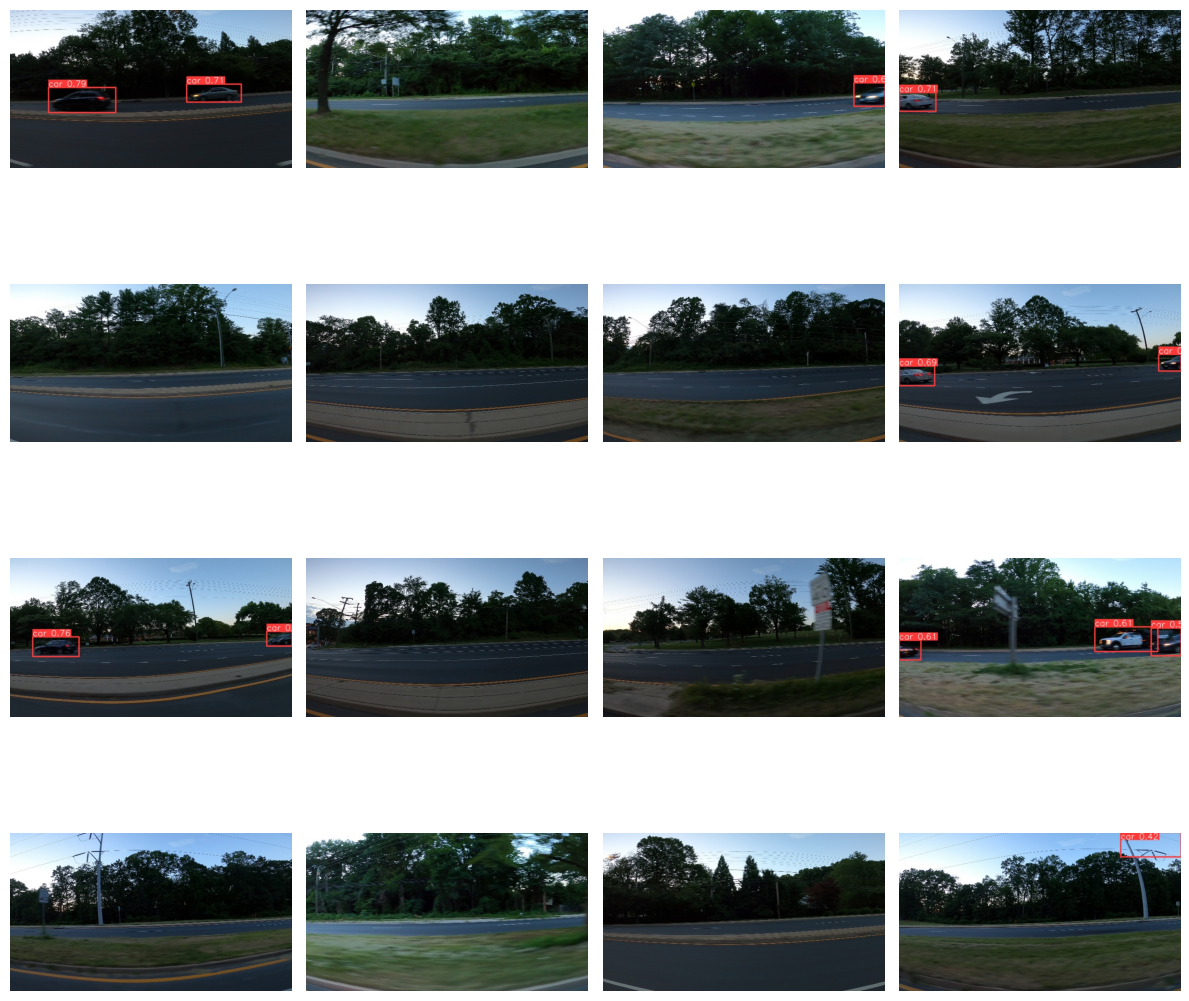

In [15]:
predictions = glob.glob(os.path.join('/kaggle/working/', 'runs/detect/predict', '*'))
rows, columns = 4, 4
total_images = rows * columns
num_images = min(total_images, len(predictions))
random_indices = np.random.choice(len(predictions), num_images, replace=False)
fig, axes = plt.subplots(rows, columns, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < num_images:
        idx = random_indices[i]
        image_path = predictions[idx]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')  
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()